Guillaume Chaslot <guillaume.chaslot@data.gouv.fr>

#  Visulal Comparator for simulators

There are several simulators for the same tax (e.g., irpp), it is important to compare them to detect bugs.
This notebook propose a vizualization of the comparisons

## How to improve the comparator

* add a case cerfa with the distribution you like in CerfaPopulationSimulator in population_simulator.py
* add method to convert this case cerfa to the correct input for each comparator (M / Openfisca / Online) in input_variable_converter.py. Most conversion CERFA -> M and CERFA -> Online are already working
* run a comparison, e.g.: "python simulate_comparators --tests=2000 --save='my_comparison' --ir"
* vizualize the results in this notebook by loading the results saved in "my_comparison"

In [38]:
from compare_simulators import CalculatorComparator
from population_simulator import CerfaPopulationSimulator
from utils import multi_scatter

import matplotlib.pyplot as plt
import pandas as pd
import qgrid
import copy

%matplotlib inline

# Define which test results you want to display

In [39]:
# Creating the comparator and loading existing results

comp = CalculatorComparator()

# Load comparison that were already done
comp.load_results_from_json('1aj-1bj-f-2000')

# If you want to run tests comparing openfisca / M / Online, run:
# 'python simulate_comparators', which arguments are the following:

#   --tests     The number of "declaration of revenu" to simulate
#   --ir        If we only compute the "impot sur le revenu"
#   --save      Saves the result in a given json file
#   --load      Loads test results from the given json file
#   --linear   If we generate from a linear distribution instead of a
#                    gaussian one.

# If you want to change the population simulated, you can do so in CerfaPopulationSimulator

In [40]:
# Adding both salaries
salaire1 = comp.get_variable_from_testcases('1AJ')
salaire2 = comp.get_variable_from_testcases('1BJ')
salaire = list([(salaire1[i] + salaire2[i]) for i in range(0, len(salaire1))])

revdisp = comp.get_variable_from_openfisca('revdisp')
impot_openfisca = comp.get_variable_from_openfisca('irpp') 
impot_m = comp.get_variable_from_m('IRN')
impot_online = comp.get_variable_from_online('IINET')

# Plotting impot sur le revenu for different calculators

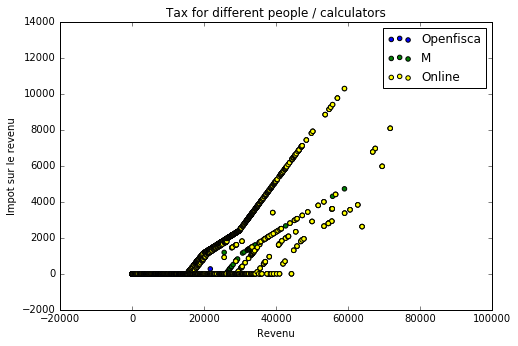

In [41]:
multi_scatter('Tax for different people / calculators', 'Revenu', 'Impot sur le revenu', [
                  {'x':salaire, 'y':impot_openfisca, 'label':'Openfisca', 'color':'blue'},
                  {'x':salaire, 'y':impot_m, 'label':'M', 'color':'green'},
                  {'x':salaire, 'y':impot_online, 'label':'Online', 'color':'yellow'},
              ])

# Computing and plotting the differences between calculators

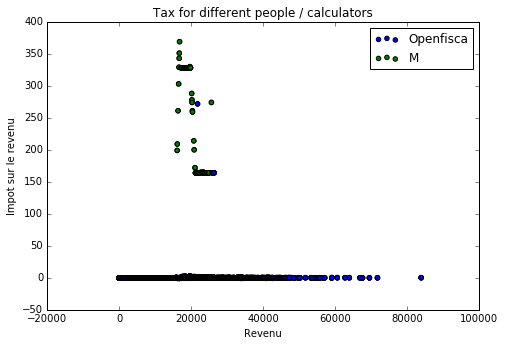

In [42]:
diff_openfisca = [a_i - b_i for a_i, b_i in zip(impot_openfisca, impot_online)]
diff_m = [a_i - b_i for a_i, b_i in zip(impot_m, impot_online)]

# TOOL 1 to find discrepencies: differences

# Plotting difference between:
# 1) openfisca and online
# 2) m and online

# x = salary (1AJ)
# y_yellow = difference between openfisca and online calculator
# y_blue = difference between m and online calculator

####################################
# Filtering dimensions of interest #
####################################
for i in range(0, len(salaire1)):
    #Removing veufs and children
     if ('V' in comp.testcases[i]):
#             or ('F' in comp.testcases[i] and comp.testcases[i]['F'] > 0)):
#     if ('F' in comp.testcases[i] and comp.testcases[i]['F'] != 2):    
        diff_m[i] = 0
#         diff_openfisca[i] = -1000

multi_scatter('Tax for different people / calculators', 'Revenu', 'Impot sur le revenu', [
                  {'x':salaire, 'y':diff_openfisca, 'label':'Openfisca', 'color':'blue'},
                  {'x':salaire, 'y':diff_m, 'label':'M', 'color':'green'},
              ])

plt.scatter(
    salaire + salaire,
    diff_m + diff_openfisca,
    c=['green'] * len(diff_m) + ['blue'] * len(diff_openfisca))

# Finding a commun ground between calculators

In [43]:

# Computing Probable outliner:
# if two calculators are equal and one is different, the different might be the one buggy

def commun(a, b, c):
    diffa = min(abs(a-b), abs(a-c))
    diffb = min(abs(a-b), abs(b-c))
    diffc = min(abs(c-b), abs(a-c))

    if diffa <= diffb and diffa <= diffc:
        return a
    if diffb <= diffa and diffb <= diffc:
        return b
    if diffc <= diffa and diffc <= diffb:
        return c
    # We do not handle yet the hypothetic case of a circular reference
    print 'Circular condition, please define behavior here' 
    assert(False)

probable_true_tax = []
for i in range(0, len(impot_m)):
    probable_true_tax.append(commun(impot_m[i], impot_online[i], impot_openfisca[i]))

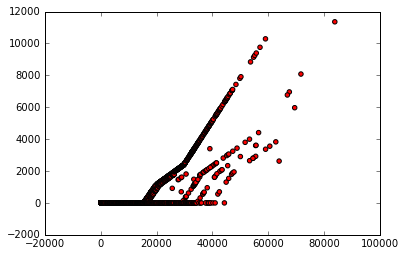

In [44]:
# x = salary
# y = probable_true_tax

plt.scatter(
    salaire,
    probable_true_tax,
    c= ['red'] * len(probable_true_tax))

# Visualizing errors of OpenFisca

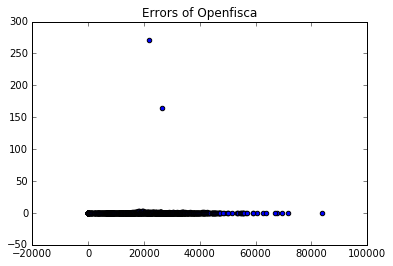

In [45]:
error_openfisca = [abs(a_i - b_i) for a_i, b_i in zip(impot_openfisca, probable_true_tax)]

plt.title('Errors of Openfisca')
plt.scatter(
    salaire,
    error_openfisca)


# Visualizing the errors of m

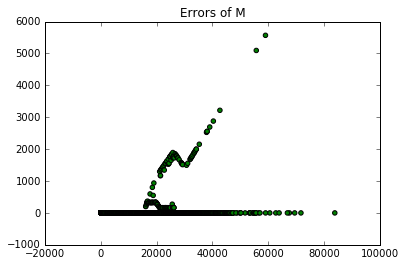

In [46]:
error_m = [abs(a_i - b_i) for a_i, b_i in zip(impot_m, probable_true_tax)]

plt.title('Errors of M')
plt.scatter(
    salaire,
    error_m,
    c=['green'] * len(impot_m))

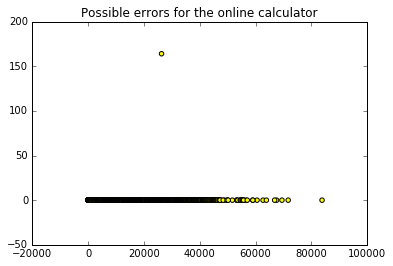

In [47]:
# Errors of online
error_online = [abs(a_i - b_i) for a_i, b_i in zip(impot_online, probable_true_tax)]

plt.title('Possible errors for the online calculator')
plt.scatter(
    salaire,
    error_online,
    c=['yellow'] * len(impot_online))

In [48]:
# TOOL 3 to find discrepencies: showing worst testcases

def get_highest_discrepencies(my_list):
    index_errors = sorted(range(len(my_list)), key=lambda k: my_list[k], reverse=True)
    average_age = 0

    from input_variable_converter import CerfaOpenFiscaConverter
    input_converter = CerfaOpenFiscaConverter()
    worst_testcases = []
    display_data = []
    for i in range(0, len(salaire)):
        idx = index_errors[i]
        new_datum =copy.deepcopy(comp.testcases[index_errors[i]])
        new_datum['Diff openfisca: '] = abs(int(impot_openfisca[idx]) - int(impot_online[idx]))
        new_datum['Diff m: '] = abs(int(impot_m[idx]) - int(impot_online[idx]))
        new_datum['Impot m: '] = int(impot_m[idx])
        new_datum['Impot openfisca: '] = int(impot_openfisca[idx])
        new_datum['Impot online: '] = int(impot_online[idx])

        display_data.append(new_datum)
    return display_data

# Investigating errors of OpenFisca

In [49]:
worst_testcases = get_highest_discrepencies(error_openfisca)

df = pd.DataFrame(data=worst_testcases)
df.set_index('Diff openfisca: ', inplace=True)
qgrid.show_grid(df)


# Investigating errors of M

In [57]:
worst_testcases = get_highest_discrepencies(error_m)

df = pd.DataFrame(data=worst_testcases)
df.set_index('Diff m: ', inplace=True)
qgrid.show_grid(df)


# Showing the Marginal tax rate

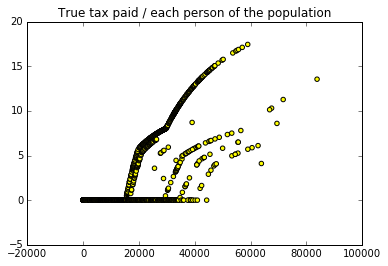

In [52]:


probable_true_marginal_rate = []
for i in range(0, len(salaire)):
    probable_true_marginal_rate.append(100 * probable_true_tax[i] / (salaire[i]+0.01))
plt.title('True tax paid / each person of the population')
plt.scatter(
    salaire,
    probable_true_marginal_rate,
    c=['yellow'] * len(impot_online))

In [53]:
# TOOL 4 to find discrepencies: weighting input variables by error

# For instance, we could find a bug that people born in 1936 with a salary of 19k have a discrepency in M

combined_total = {}
combined_total_ref = {}
combined_diff = {}
for var in comp.testcases[0]:
    combined_total[var] = 0
    combined_total_ref[var] = 0
combined_weights = 0 

for i in range(0, len(salaire)):
    for var in comp.testcases[i]:
        combined_total[var] = combined_total.get(var, 0) + comp.testcases[i].get(var, 0) * error_openfisca[i]
        combined_total_ref[var] = combined_total_ref.get(var, 0) + comp.testcases[i][var]
    combined_weights += error_openfisca[i]
for var in combined_total:
    combined_total[var] = combined_total[var] / combined_weights
    combined_total_ref[var] = combined_total_ref[var] / len(salaire)
    combined_diff[var] = combined_total[var] - combined_total_ref[var]

print 'Reference average: ' + repr(combined_total_ref)
print 'Weighted by bug average: ' + repr(combined_total)
print 'Difference: ' + repr(combined_diff)


Reference average: {u'C': 0, u'D': 0, u'F': 0, u'V': 0, u'M': 0, u'O': 0, u'year': 2014, u'1BJ': 1053, u'0DB': 662, u'0DA': 1960, u'1AJ': 12602}
Weighted by bug average: {u'C': 0.20359457010326854, u'D': 0.06538539526454148, u'F': 0.4338166288344384, u'V': 0.6846897009609086, u'M': 0.0415385305543842, u'O': 0.0047918031168970995, u'year': 2014.0, u'1BJ': 400.3854568129413, u'0DB': 90.73543967628771, u'0DA': 1954.0820438375338, u'1AJ': 24448.186745022744}
Difference: {u'C': 0.20359457010326854, u'D': 0.06538539526454148, u'F': 0.4338166288344384, u'year': 0.0, u'M': 0.0415385305543842, u'O': 0.0047918031168970995, u'V': 0.6846897009609086, u'1BJ': -652.6145431870586, u'0DB': -571.2645603237123, u'0DA': -5.917956162466226, u'1AJ': 11846.186745022744}


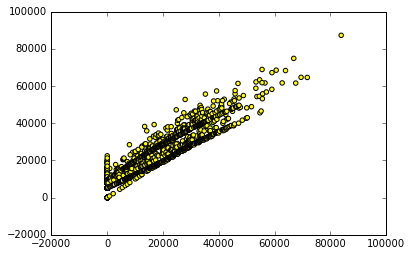

In [54]:
# Disposable income
plt.scatter(
    salaire,
    revdisp,
    c=['yellow'] * len(impot_online))

In [55]:
for i in range(0, len(salaire)):
    if revdisp[i] > salaire[i] + 18000 and ('C' in comp.testcases[i]) and ('F' in comp.testcases[i]) and comp.testcases[i]['F'] < 4:
        print revdisp[i]
        print comp.testcases[i]


18610.1621094
{u'C': 1, u'year': 2014, u'F': 3, u'0DA': 1931, u'1AJ': 0}


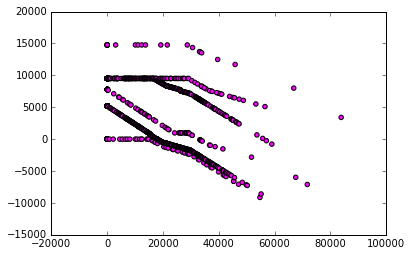

In [56]:
# Government help:
balance_x = []
balance_y = []
for i in range(0, len(salaire)):
    if ('F' not in comp.testcases[i]):
        balance_x.append(salaire[i])
        balance_y.append(revdisp[i] - salaire[i])

# Disposable income
plt.scatter(
    balance_x,
    balance_y,
    c=['magenta'] * len(impot_online))

In [20]:
# comparator.simulate_m([{u'C': 1, u'1AJ': 0, u'0DA': 1992, u'year': 2014}], {})
test = comparator.simulate_of([{u'F': 2, u'M': 1, u'year': 2014, u'1BJ': 0, u'0DB': 1950, u'0DA': 1981, u'1AJ': 0}])
# comparator.simulate_online([{u'C': 1, u'1AJ': 0, u'0DA': 1992, u'year': 2014}],{})


Simulating OF
INFO: converting birthdate from "1981" to "1981-1-1"
INFO: converting birthdate from "1950" to "1950-1-1"
{'enfants': [{'date_naissance': '2010-1-1'}, {'date_naissance': '2010-1-1'}], 'parent2': {u'salaire_imposable': 0, 'statut_marital': 1, 'date_naissance': '1950-1-1'}, 'parent1': {u'salaire_imposable': 0, 'statut_marital': 1, 'date_naissance': '1981-1-1'}, 'period': 2014}
Irpp openfisca = -0.0
Revdisp openfisca = 11140.2021484375
Openfisca took 12.1526482105 seconds
